### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2022 Semester 2

## Group Project - Stereo Matching

**Student1:**    Jiachen Huo (1293736)
    
**Student2:**    Haonan Lyu (1252105)

In [2]:
import cv2
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tqdm
from numpy.lib.stride_tricks import as_strided
import torch
import time

# Design Step


## Baseline

In [16]:
def baseline(img_left,img_right,window_size,match_function,technique):

    borderType = cv2.BORDER_REPLICATE
    padding = int((window_size - 1)/2)
    dst_left = cv2.copyMakeBorder(img_left, padding, padding, padding, padding, borderType, None, 0).astype(np.int32)
    dst_right = cv2.copyMakeBorder(img_right, padding, padding, padding, padding, borderType, None, 0).astype(np.int32)

    disparity = np.zeros((img_left.shape[0], img_left.shape[1]))

    for i in tqdm.tqdm(range(padding,img_left.shape[0])):
        for j in range(padding,img_left.shape[1]):

            left_window = dst_left[i:i+window_size,j:j+window_size]
            # if technique == "SSD" or technique == "ZSAD":
            best_disparity = np.inf
            best_diff = np.inf
            # else:
            #     best_disparity = -1
            #     best_diff = -1

            for k in range(j+1):
                right_window = dst_right[i:i+window_size,k:k+window_size]
                diff = match_function(left_window,right_window,technique)
                
                # if technique == "SSD" or technique == "ZSAD":
                if diff < best_diff:
                        best_diff = diff
                        best_disparity = np.abs(j-k)
                # else: 
                #     if diff > best_diff:
                #             best_diff = diff
                #             best_disparity = np.abs(j-k)
                            
            disparity[i,j] = best_disparity
    return disparity

In [5]:
def match_function(left_window,right_window,technique):
    if technique == "SSD":
        return np.sum((left_window-right_window)**2)

    elif technique == "NCC":
        top = np.sum(np.multiply(left_window,right_window))
        bottom = np.sqrt(np.sum(np.square(left_window))*np.sum(np.square(right_window)))
        return top/bottom

    elif technique == "ZSAD":
        return np.sum((left_window-np.mean(left_window))-(right_window-np.mean(right_window))**2)

    elif technique == "ZNCC":
        top = np.sum(np.multiply(left_window-np.mean(left_window),right_window-np.mean(right_window)))
        bottom = np.sqrt(np.multiply(np.sum(np.square(left_window-np.mean(left_window))),np.sum(np.square(right_window-np.mean(right_window)))))
        return top/bottom

## Optimization
1. Using matrix calculation to accelerate
2. Control the search area
3. gaussian weight
4. smooth

In [6]:
## Define different loss function

def cal_ssd(strided_left, strided_right, col, prev):

    strided_window = strided_left[:,col]

    right_map = torch.swapaxes(strided_right[:,prev:col+1], 0, 1)

    diff = ((right_map - strided_window) ** 2).sum(axis=-1).sum(axis=-1)

    diff = np.swapaxes(diff, 0, 1)
    
    diff = diff.cpu().detach().numpy()

    return diff

def cal_zssd(strided_left, strided_right, col, prev):

    strided_window = strided_left[:,col]

    right_map = torch.swapaxes(strided_right[:,prev:col+1], 0, 1)

    l_mean = torch.mean(torch.mean(strided_window, dim=-1),dim=-1)
    r_mean = torch.mean(torch.mean(right_map, dim=-1),dim=-1)

    strided_window = strided_window - l_mean[:, None, None]
    right_map = right_map -r_mean[:, :, None, None]

    diff = ((right_map - strided_window) ** 2).sum(axis=-1).sum(axis=-1)

    diff = np.swapaxes(diff, 0, 1)
    
    diff = diff.cpu().detach().numpy()

    return diff

def cal_zncc(strided_left, strided_right, col, prev):

    strided_window = strided_left[:,col]
    s1, s2, s3 = strided_window.shape
    strided_window = torch.reshape(strided_window, (s1, 1, s2, s3))

    right_map = strided_right[:,prev:col+1]

    l_mean = torch.mean(torch.mean(strided_window, dim=-1),dim=-1)
    r_mean = torch.mean(torch.mean(right_map, dim=-1),dim=-1)
    
    strided_window = strided_window - l_mean[:, None, None]
    right_map = right_map -r_mean[:, :, None, None]

    top = ((strided_window) * (right_map)).sum(axis=-1).sum(axis=-1)
    bottom = torch.sqrt(torch.square(strided_window).sum(axis=-1).sum(axis=-1) * 
                        torch.square(right_map).sum(axis=-1).sum(axis=-1)).squeeze() + 1e-6
    diff = top/bottom

    diff = diff.cpu().detach().numpy()

    return diff

## Helper function 

def pad_img(img, padding):

    borderType = cv2.BORDER_CONSTANT

    padded_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, borderType, None, 0).astype(np.float32)

    return padded_img

def stride_img(img, original_size, window_size):

    strided_img = as_strided(img, shape = (original_size[0],original_size[1],window_size,window_size),strides=img.strides * 2)
    strided_img = torch.from_numpy(strided_img)
    strided_img.cuda()

    return strided_img

def get_2d_gaussian_kernel(size, sigma=0):
    kernel_1d = cv2.getGaussianKernel(size, sigma, ktype=cv2.CV_32F)
    kernel_2d = kernel_1d * kernel_1d.T

    kernel_2d = torch.from_numpy(kernel_2d)
    kernel_2d.cuda()
    
    return kernel_2d


# Evaluation Step

## Subpixel evaluation function

In [7]:
def metric_evaluation(disparity, ground_truth):
    valid_mask = ground_truth > 0
    disparity = disparity * valid_mask

    invalid_num = np.sum(ground_truth == 0)
    valid_num = np.sum(valid_mask)

    error = np.abs(disparity - ground_truth)
    error_0_25 = (np.sum(error < 0.25) - invalid_num) / valid_num
    error_0_5 = (np.sum(error < 0.5) - invalid_num) / valid_num
    error_1 = (np.sum(error < 1) - invalid_num) / valid_num
    error_2 = (np.sum(error < 2) - invalid_num) / valid_num
    error_4 = (np.sum(error < 4) - invalid_num) / valid_num
    prop = np.array([error_0_25, error_0_5, error_1, error_2, error_4])

    rms = np.sqrt(np.sum((disparity - ground_truth) ** 2) / valid_num)
    return prop, rms

## Load sample image

In [8]:
rootpath='./Dataset/'

ground_truth1 = cv2.imread(os.path.join(rootpath, "2018-07-09-16-11-56_2018-07-09-16-46-51-712-disparity.png"), -1)/256

img_left1 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-46-51-712-left.jpg"),cv2.IMREAD_GRAYSCALE)
img_right1 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-46-51-712-right.jpg"),cv2.IMREAD_GRAYSCALE)

ground_truth2 = cv2.imread(os.path.join(rootpath, "2018-07-09-16-11-56_2018-07-09-16-51-40-823-disparity.png"), -1)/256

img_left2 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-51-40-823-left.jpg"),cv2.IMREAD_GRAYSCALE)
img_right2 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-51-40-823-right.jpg"),cv2.IMREAD_GRAYSCALE)

ground_truth3 = cv2.imread(os.path.join(rootpath, "2018-07-09-16-11-56_2018-07-09-16-49-27-623-disparity.png"), -1)/256

img_left3 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-49-27-623-left.jpg"),cv2.IMREAD_GRAYSCALE)
img_right3 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-49-27-623-right.jpg"),cv2.IMREAD_GRAYSCALE)

ground_truth4 = cv2.imread(os.path.join(rootpath, "2018-07-09-16-11-56_2018-07-09-16-13-38-366-disparity.png"), -1)/256

img_left4 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-13-38-366-left.jpg"),cv2.IMREAD_GRAYSCALE)
img_right4 = cv2.imread(os.path.join(rootpath,"2018-07-09-16-11-56_2018-07-09-16-13-38-366-right.jpg"),cv2.IMREAD_GRAYSCALE)

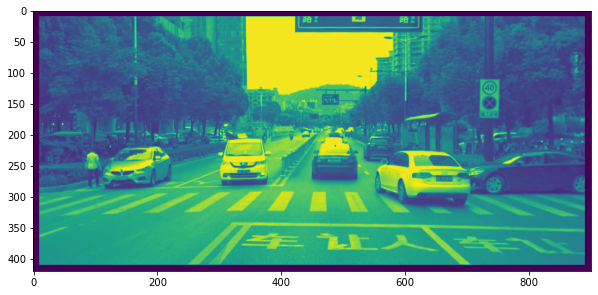

In [9]:
borderType = cv2.BORDER_CONSTANT
# borderType = cv2.BORDER_REPLICATE
window_size = 21
padding = int((window_size - 1)/2)
dst = cv2.copyMakeBorder(img_left1, padding, padding, padding, padding, borderType, None, 0)
plt.subplots(figsize=(10, 10)) 
plt.imshow(dst)

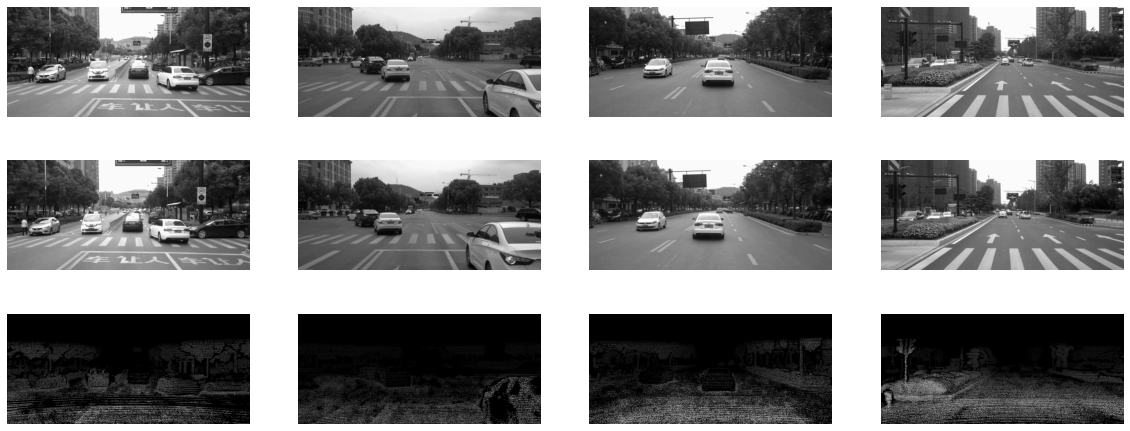

In [10]:
plt.subplots(figsize=(20,8))
plt.subplot(3, 4, 1)
plt.imshow(img_left1, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 2)
plt.imshow(img_left2, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 3)
plt.imshow(img_left3, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 4)
plt.imshow(img_left4, cmap='gray')
plt.axis('off')


plt.subplot(3, 4, 5)
plt.imshow(img_right1, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 6)
plt.imshow(img_right2, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 7)
plt.imshow(img_right3, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 8)
plt.imshow(img_right4, cmap='gray')
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(ground_truth1, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 10)
plt.imshow(ground_truth2, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 11)
plt.imshow(ground_truth3, cmap='gray')
plt.axis('off')
plt.subplot(3, 4, 12)
plt.imshow(ground_truth4, cmap='gray')
plt.axis('off')


plt.show()

In [14]:
win_sizes = [3,7,11,15,19,23]
lst_l = [img_left1, img_left2, img_left3, img_left4]
lst_r = [img_right1, img_right2, img_right3, img_right4]
lst_g = [ground_truth1, ground_truth2, ground_truth3, ground_truth4]

## Baseline
Evaluation of the baseline model

In [18]:
def eval_bsae(lst_l, lst_r, lst_g, match_function):
    rms_l, prop_l = [], []
    for img in range(len(lst_l)):
        
        ssd = baseline(lst_l[img],lst_r[img],13,match_function,"SSD")
        prop, rms = metric_evaluation(ssd,lst_g[img]) 

        rms_l.append(rms)
        prop_l.append(prop)

    return rms_l, prop_l

In [19]:
rms_base, prop_base = eval_bsae(lst_l, lst_r, lst_g, match_function)
print(np.mean(rms_base))
print(np.mean(prop_base,axis=0))

100%|██████████| 394/394 [10:00<00:00,  1.52s/it]

100.31828906967337
[0.16525888 0.32072036 0.50167657 0.63675211 0.69517839]


Define function to draw curves to find the best window size

## Finding SSD Best window size 
Best Size xx?
